# Credit score classification - grupa nr 5: Wojtek Grabias, Wiktor Wierzchowski

## importy, split i funkcje

In [595]:
%%capture --no-stderr

import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import MultiLabelBinarizer
from datetime import datetime
from pandas.api.types import is_numeric_dtype
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
np.random.seed(29)

In [596]:
df_original = pd.read_csv('train.csv', low_memory=False)

df, X_test, df_target, y_test = train_test_split(
    df_original[df_original.columns.values[:-1]], # X
    df_original[df_original.columns.values[-1]], # y
    test_size=0.30, random_state=42)

## Dalsza prezentacja tylko dla ramki treningowej, proces działania dla ramki walidacyjnej w pełni analogiczny.

In [597]:
def History_Age_2_months(df):
    df['Credit_History_Age'] = df['Credit_History_Age'].str.replace(' Months', '')
    return df['Credit_History_Age'].str.replace('\D+', '* 12 +')
def Object_to_Numeric(df, s):
    return pd.to_numeric(df[s].str.replace('_', ''))

## podstawowe zaznajomienie z ramką

In [598]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70000 entries, 76513 to 15795
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        70000 non-null  object 
 1   Customer_ID               70000 non-null  object 
 2   Month                     70000 non-null  object 
 3   Name                      63016 non-null  object 
 4   Age                       70000 non-null  object 
 5   SSN                       70000 non-null  object 
 6   Occupation                70000 non-null  object 
 7   Annual_Income             70000 non-null  object 
 8   Monthly_Inhand_Salary     59510 non-null  float64
 9   Num_Bank_Accounts         70000 non-null  int64  
 10  Num_Credit_Card           70000 non-null  int64  
 11  Interest_Rate             70000 non-null  int64  
 12  Num_of_Loan               70000 non-null  object 
 13  Type_of_Loan              61973 non-null  object 
 14  De

In [599]:
df.columns

Index(['ID', 'Customer_ID', 'Month', 'Name', 'Age', 'SSN', 'Occupation',
       'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Type_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Credit_History_Age',
       'Payment_of_Min_Amount', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance'],
      dtype='object')

In [600]:
df['ID'].drop_duplicates().shape[0]
# każdy wiersz ma swoje id więc wszystkie wpisy w tabeli są unikalne
# df = df.drop(columns = ['ID', 'Name', 'SSN'])

70000

## zamiana typów kolumn na numeryczne

In [601]:
df['Outstanding_Debt'] = Object_to_Numeric(df, 'Outstanding_Debt')
df['Amount_invested_monthly'] = Object_to_Numeric(df, 'Amount_invested_monthly')
df['Changed_Credit_Limit'] = Object_to_Numeric(df, 'Changed_Credit_Limit')
df['Monthly_Balance'] = df['Monthly_Balance'].str.replace('_', '')
df = df.astype({'Monthly_Balance': 'float'})

In [602]:
df['Credit_History_Age'] = History_Age_2_months(df)
df['Credit_History_Age'].loc[df.Credit_History_Age.isnull()] = df['Credit_History_Age'].loc[df.Credit_History_Age.isnull()].apply(
        lambda x: '-1') #Brak danych jest teraz -1
df['Credit_History_Age'] = df['Credit_History_Age'].apply(eval)

C:\Users\wojte\AppData\Local\Temp\ipykernel_94776\2355454557.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  return df['Credit_History_Age'].str.replace('\D+', '* 12 +')
c:\users\wojte\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [603]:
df['Payment_of_Min_Amount'] = df['Payment_of_Min_Amount'].replace('Yes', 1)
df['Payment_of_Min_Amount'] = df['Payment_of_Min_Amount'].replace('No', 0)
df['Payment_of_Min_Amount'] = df['Payment_of_Min_Amount'].replace('NM', 2)
df['Payment_Behaviour'] = np.where(df['Payment_Behaviour']== '!@9#%8', np.nan, df['Payment_Behaviour'])
df['spent'] = np.where('Low' == df['Payment_Behaviour'].str[0:3], 0,1)
df['payment_value'] = df['Payment_Behaviour'].str.extract(r'^(?:[^_]+_){2}([^_ ]+)')

In [604]:
df['payment_value'] = df['payment_value'].replace('Small', 0)
df['payment_value'] = df['payment_value'].replace('Medium', 1)
df['payment_value'] = df['payment_value'].replace('Large', 2)

In [605]:
df['payment_value'] = np.where(df['payment_value'] == 3, np.nan, df['payment_value'])
df = df.drop('Payment_Behaviour', axis=1)

In [606]:
df['Type_of_Loan'] = df['Type_of_Loan'].str.replace('and ', '')
df.Type_of_Loan = df.Type_of_Loan.str.split(', ')
df['Type_of_Loan'].loc[df.Type_of_Loan.isnull()] = df['Type_of_Loan'].loc[df.Type_of_Loan.isnull()].apply(lambda x: [])
mlb = MultiLabelBinarizer(sparse_output=True)
df = df.join(
    pd.DataFrame.sparse.from_spmatrix(
        mlb.fit_transform(df.pop('Type_of_Loan')),
        index=df.index,
        columns=mlb.classes_))

c:\users\wojte\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [607]:
#2 Month na numeric
df['Month'] = df['Month'].apply(lambda mname: datetime.strptime(mname, '%B').month)

#4 Age na numeric
df['Age'] = df['Age'].convert_dtypes().apply(lambda x: x.replace("_", "")).astype(int)

#7 Annual_Income na numeric
df['Annual_Income'] = df['Annual_Income'].convert_dtypes().apply(lambda x: x.replace("_", "")).astype(float)

#12 Num_of_Loan na numeric
df['Num_of_Loan'] = df['Num_of_Loan'].convert_dtypes().apply(lambda x: x.replace("_", "")).astype(int)

#15 Num_of_Delayed_Payment na numeric
df['Num_of_Delayed_Payment'] = df['Num_of_Delayed_Payment'].convert_dtypes()
df['Num_of_Delayed_Payment'] = df['Num_of_Delayed_Payment'].str.replace('_', '')
df['Num_of_Delayed_Payment'] = pd.to_numeric(df['Num_of_Delayed_Payment'])

## One-hot

In [608]:
# Credit_Mix na numeric
df['Credit_Mix'] = df['Credit_Mix'].replace('_', 3)
df['Credit_Mix'] = df['Credit_Mix'].replace('Good', 2)
df['Credit_Mix'] = df['Credit_Mix'].replace('Standard', 1)
df['Credit_Mix'] = df['Credit_Mix'].replace('Bad', 0)

# Credit_Score na numeric
df_target = df_target.replace('Good', 2)
df_target = df_target.replace('Standard', 1)
df_target = df_target.replace('Poor', 0)

In [609]:
df.drop(columns=['ID','Customer_ID','Name','SSN'], inplace=True)

In [610]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70000 entries, 76513 to 15795
Data columns (total 32 columns):
 #   Column                    Non-Null Count  Dtype           
---  ------                    --------------  -----           
 0   Month                     70000 non-null  int64           
 1   Age                       70000 non-null  int32           
 2   Occupation                70000 non-null  object          
 3   Annual_Income             70000 non-null  float64         
 4   Monthly_Inhand_Salary     59510 non-null  float64         
 5   Num_Bank_Accounts         70000 non-null  int64           
 6   Num_Credit_Card           70000 non-null  int64           
 7   Interest_Rate             70000 non-null  int64           
 8   Num_of_Loan               70000 non-null  int32           
 9   Delay_from_due_date       70000 non-null  int64           
 10  Num_of_Delayed_Payment    65073 non-null  float64         
 11  Changed_Credit_Limit      68510 non-null  float64 

## Usuwanie błędnych wartości

In [611]:
df = df[df.Monthly_Balance != min(df.Monthly_Balance)]
df.Credit_History_Age = np.where(df.Credit_History_Age == -1, np.nan, df.Credit_History_Age)
df.Amount_invested_monthly = np.where(df.Amount_invested_monthly == 10000, np.nan, df.Amount_invested_monthly)
df.Num_Bank_Accounts = np.where(df.Num_Bank_Accounts == -1, np.nan, df.Num_Bank_Accounts)

In [612]:
df['Age'] = np.where(df['Age'] < 0, np.nan, df['Age'])

In [613]:
df['Num_of_Loan'] = np.where(df['Num_of_Loan'] < 0, np.nan, df['Num_of_Loan'])

In [614]:
df['Changed_Credit_Limit'] = np.where(df['Changed_Credit_Limit'] < 0, np.nan, df['Changed_Credit_Limit'])

## Usuwanie nan

In [615]:
#Usunięcie tych, które mają 4 lub więcej nulle
df = df[df.isnull().sum(axis=1) < 4]

## Zamiana nan na medianę/modę

In [616]:
df['Age'].fillna(df['Age'].median(), inplace=True) 
df['Num_Bank_Accounts'].fillna(df['Num_Bank_Accounts'].median(), inplace=True) 
df['Num_of_Loan'].fillna(df['Num_of_Loan'].median(), inplace=True) 
df['Num_of_Delayed_Payment'].fillna(df['Num_of_Delayed_Payment'].median(), inplace=True) 
df['Num_Bank_Accounts'].fillna(df['Num_Bank_Accounts'].median(), inplace=True) 
df['Changed_Credit_Limit'].fillna(df['Changed_Credit_Limit'].median(), inplace=True) 
df['Num_Credit_Inquiries'].fillna(df['Num_Credit_Inquiries'].median(), inplace=True) 
df['Credit_History_Age'].fillna(df['Credit_History_Age'].median(), inplace=True) 
df['Amount_invested_monthly'].fillna(df['Amount_invested_monthly'].median(), inplace=True) 
df['Monthly_Inhand_Salary'].fillna(df['Monthly_Inhand_Salary'].median(), inplace=True) 
df['Monthly_Balance'].fillna(df['Monthly_Balance'].median(), inplace=True) 
df['payment_value'].fillna(df['payment_value'].mode(), inplace=True) 

In [617]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69882 entries, 76513 to 15795
Data columns (total 32 columns):
 #   Column                    Non-Null Count  Dtype           
---  ------                    --------------  -----           
 0   Month                     69882 non-null  int64           
 1   Age                       69882 non-null  float64         
 2   Occupation                69882 non-null  object          
 3   Annual_Income             69882 non-null  float64         
 4   Monthly_Inhand_Salary     69882 non-null  float64         
 5   Num_Bank_Accounts         69882 non-null  float64         
 6   Num_Credit_Card           69882 non-null  int64           
 7   Interest_Rate             69882 non-null  int64           
 8   Num_of_Loan               69882 non-null  float64         
 9   Delay_from_due_date       69882 non-null  int64           
 10  Num_of_Delayed_Payment    69882 non-null  float64         
 11  Changed_Credit_Limit      69882 non-null  float64 

## Poprawienie outlierów i standaryzacja

#### Każdą z kolumn potraktowaliśmy jako osobny byt i w zależności od potrzeb outlier'y (nie) zostały zamieniony na wartość odpowiedniego percentyla.

In [618]:
#kolumny o małych przedziałach wartości zostawiliśmy bez standaryzacji 
stdscaler = StandardScaler()
mmscaler = MinMaxScaler()

df = df.reset_index(drop=True)

Annual_Income

In [619]:
df.Annual_Income.describe()

count    6.988200e+04
mean     1.770809e+05
std      1.440022e+06
min      7.005930e+03
25%      1.952799e+04
50%      3.773142e+04
75%      7.279092e+04
max      2.419806e+07
Name: Annual_Income, dtype: float64

In [620]:
#Tylko górne
upper_lim = df.Annual_Income.quantile(.99)
df.Annual_Income = np.where(df.Annual_Income > upper_lim, upper_lim, df.Annual_Income)

df = df.reset_index(drop=True)
df.Annual_Income = pd.DataFrame(mmscaler.fit_transform(pd.DataFrame(df.Annual_Income)),columns=['Annual_Income'])

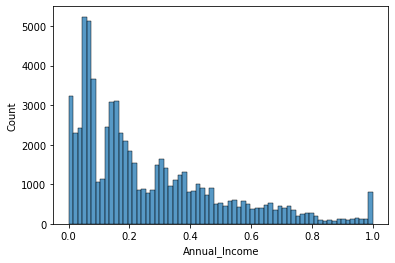

In [621]:
plot_dens=sns.histplot(df['Annual_Income'])

Monthly Balance

In [622]:
df.Monthly_Balance = pd.DataFrame(mmscaler.fit_transform(pd.DataFrame(df.Monthly_Balance)),columns=['Monthly_Balance'])

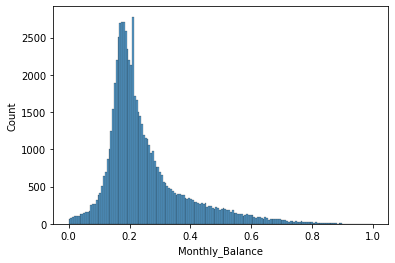

In [623]:
plot_dens=sns.histplot(df['Monthly_Balance'])

Amount_invested_monthly

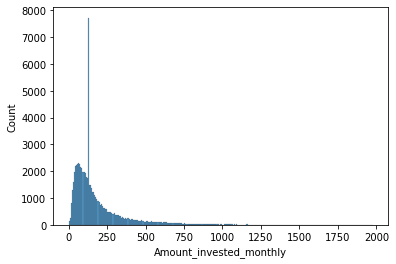

In [624]:
plot_dens=sns.histplot(df['Amount_invested_monthly'])

In [625]:
#Tylko górne
upper_lim = df.Amount_invested_monthly.quantile(.99)
df.Amount_invested_monthly = np.where(df.Amount_invested_monthly > upper_lim, upper_lim, df.Amount_invested_monthly)
df.Amount_invested_monthly = np.log1p(df.Amount_invested_monthly)

df = df.reset_index(drop=True)

In [626]:
df.Amount_invested_monthly = pd.DataFrame(mmscaler.fit_transform(pd.DataFrame(df.Amount_invested_monthly)),columns=['Amount_invested_monthly'])

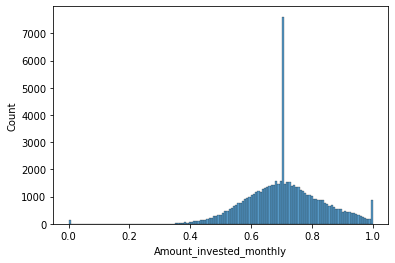

In [627]:
plot_dens=sns.histplot(df['Amount_invested_monthly'])

Total_EMI_per_month

In [628]:
df.Total_EMI_per_month.describe()

count    69882.000000
mean      1426.444398
std       8379.558127
min          0.000000
25%         30.230996
50%         69.246684
75%        162.238963
max      82331.000000
Name: Total_EMI_per_month, dtype: float64

In [629]:
#Ponownie tylko górne
upper_lim = df.Total_EMI_per_month.quantile(.96)
df.Total_EMI_per_month = np.where(df.Total_EMI_per_month > upper_lim, upper_lim, df.Total_EMI_per_month)
df = df.reset_index(drop=True)

df.Total_EMI_per_month = np.log1p(df.Total_EMI_per_month)

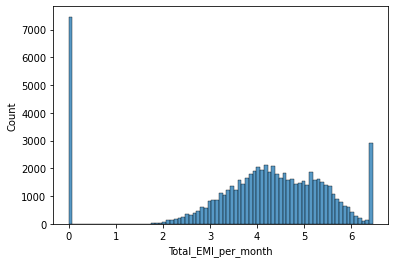

In [630]:
plot_dens=sns.histplot(df['Total_EMI_per_month'])

Credit_Utilization_Ratio

In [631]:
df.Credit_Utilization_Ratio = pd.DataFrame(mmscaler.fit_transform(pd.DataFrame(df.Credit_Utilization_Ratio)),columns=['Credit_Utilization_Ratio'])

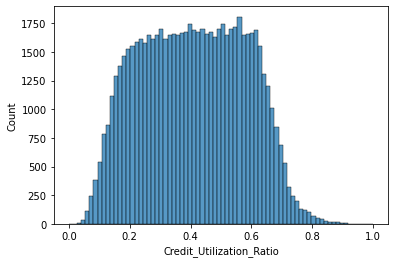

In [632]:
plot_dens=sns.histplot(df['Credit_Utilization_Ratio'])

Outstanding_Debt 

In [633]:
df.Outstanding_Debt = pd.DataFrame(mmscaler.fit_transform(pd.DataFrame(df.Outstanding_Debt)),columns=['Outstanding_Debt'])

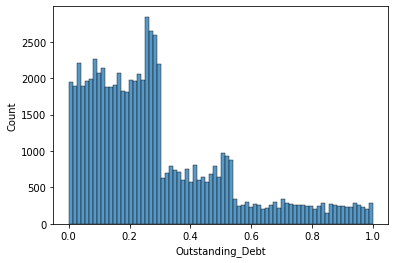

In [634]:
plot_dens=sns.histplot(df['Outstanding_Debt'])

Num_Credit_Inquiries

In [635]:
df.Num_Credit_Inquiries.describe()

count    69882.000000
mean        27.399330
std        191.075056
min          0.000000
25%          3.000000
50%          6.000000
75%          9.000000
max       2597.000000
Name: Num_Credit_Inquiries, dtype: float64

In [636]:
upper_lim = df.Num_Credit_Inquiries.quantile(.96)
df.Num_Credit_Inquiries = np.where(df.Num_Credit_Inquiries > upper_lim, upper_lim, df.Num_Credit_Inquiries)

df = df.reset_index(drop=True)

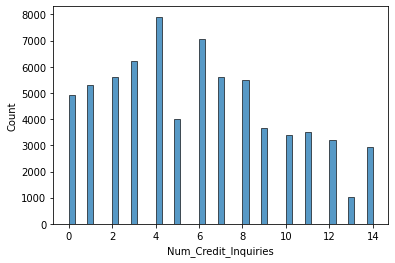

In [637]:
plot_dens=sns.histplot(df['Num_Credit_Inquiries'])

Changed_Credit_Limit

In [638]:
df.Changed_Credit_Limit = pd.DataFrame(mmscaler.fit_transform(pd.DataFrame(df.Changed_Credit_Limit)),columns=['Changed_Credit_Limit'])

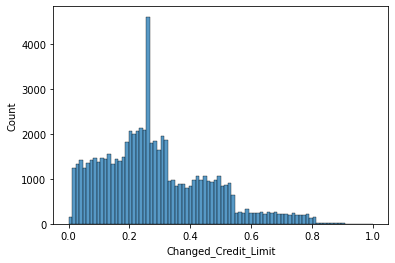

In [639]:
plot_dens=sns.histplot(df['Changed_Credit_Limit'])

Age

In [640]:
df.Age.describe()

count    69882.000000
mean       114.833305
std        682.549882
min         14.000000
25%         25.000000
50%         33.000000
75%         42.000000
max       8698.000000
Name: Age, dtype: float64

In [641]:
df[df.Age==14].shape

(846, 32)

In [642]:
upper_lim = df.Age.quantile(.98)
df.Age = np.where(df.Age > upper_lim, upper_lim, df.Age)
df = df.reset_index(drop=True)


df.Age = pd.DataFrame(mmscaler.fit_transform(pd.DataFrame(df.Age)),columns=['Age'])

<AxesSubplot:xlabel='Age', ylabel='Count'>

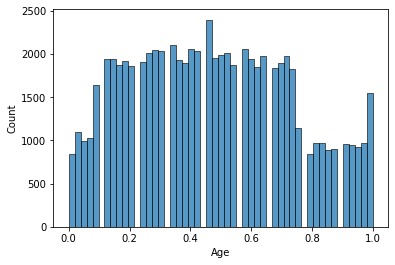

In [643]:
sns.histplot(df.Age)

In [644]:
factor=3

Monthly_Inhand_Salary

<AxesSubplot:xlabel='Monthly_Inhand_Salary', ylabel='Count'>

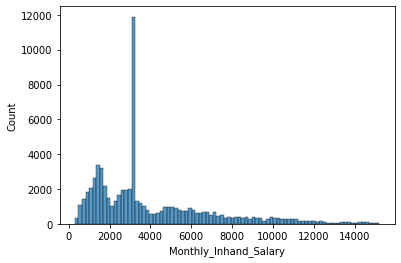

In [645]:
sns.histplot(df.Monthly_Inhand_Salary)

Num_Bank_Accounts

In [646]:
df.Num_Bank_Accounts.describe()

count    69882.000000
mean        17.423070
std        118.827581
min          0.000000
25%          3.000000
50%          6.000000
75%          7.000000
max       1798.000000
Name: Num_Bank_Accounts, dtype: float64

<AxesSubplot:xlabel='Num_Bank_Accounts', ylabel='Count'>

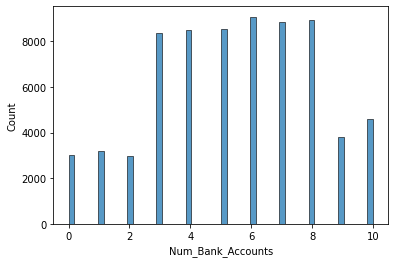

In [647]:
upper_lim = df.Num_Bank_Accounts.quantile(.98)
lower_lim = df.Num_Bank_Accounts.quantile(.00)
df.Num_Bank_Accounts = np.where(df.Num_Bank_Accounts > upper_lim, upper_lim, df.Num_Bank_Accounts)
df.Num_Bank_Accounts = np.where(df.Num_Bank_Accounts < lower_lim, lower_lim, df.Num_Bank_Accounts)
df = df.reset_index(drop=True)

sns.histplot(df.Num_Bank_Accounts)

Num_Credit_Card

<AxesSubplot:xlabel='Num_Credit_Card', ylabel='Count'>

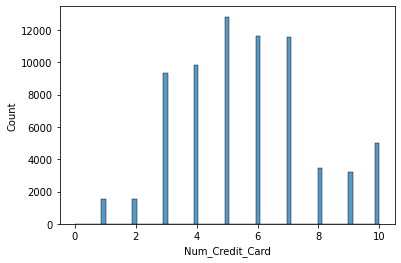

In [648]:
upper_lim = df.Num_Credit_Card.quantile(.97)
lower_lim = df.Num_Credit_Card.quantile(.00)
df.Num_Credit_Card = np.where(df.Num_Credit_Card > upper_lim, upper_lim, df.Num_Credit_Card)
df.Num_Credit_Card = np.where(df.Num_Credit_Card < lower_lim, lower_lim, df.Num_Credit_Card)

df = df.reset_index(drop=True)

sns.histplot(df.Num_Credit_Card)

Interest_Rate

In [649]:
df.Interest_Rate.describe()

count    69882.000000
mean        73.433388
std        471.043156
min          1.000000
25%          8.000000
50%         13.000000
75%         20.000000
max       5797.000000
Name: Interest_Rate, dtype: float64

<AxesSubplot:xlabel='Interest_Rate', ylabel='Count'>

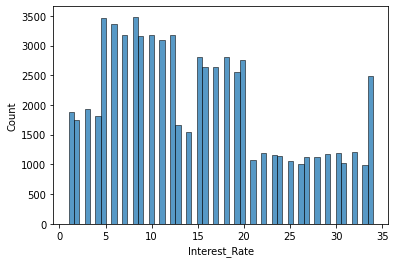

In [650]:
upper_lim = df.Interest_Rate.quantile(.97)
df.Interest_Rate = np.where(df.Interest_Rate > upper_lim, upper_lim, df.Interest_Rate)
df = df.reset_index(drop=True)

sns.histplot(df.Interest_Rate)

Num_of_Loan

In [651]:
df.Num_of_Loan.describe()

count    69882.000000
mean         6.676970
std         56.129256
min          0.000000
25%          2.000000
50%          3.000000
75%          5.000000
max       1485.000000
Name: Num_of_Loan, dtype: float64

<AxesSubplot:xlabel='Num_of_Loan', ylabel='Count'>

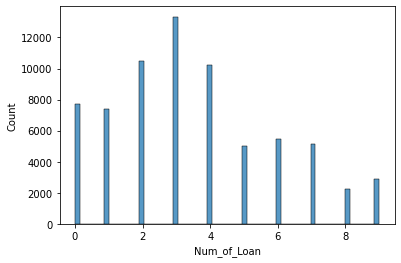

In [652]:
upper_lim = df.Num_of_Loan.quantile(.99)
df.Num_of_Loan = np.where(df.Num_of_Loan > upper_lim, upper_lim, df.Num_of_Loan)
df = df.reset_index(drop=True)

sns.histplot(df.Num_of_Loan)

Delay_from_due_date

In [653]:
df.Delay_from_due_date.describe()

count    69882.000000
mean        21.023511
std         14.839126
min         -5.000000
25%         10.000000
50%         18.000000
75%         28.000000
max         67.000000
Name: Delay_from_due_date, dtype: float64

<AxesSubplot:xlabel='Delay_from_due_date', ylabel='Count'>

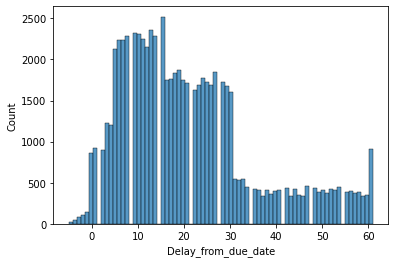

In [654]:
upper_lim = df.Delay_from_due_date.quantile(.99)
df.Delay_from_due_date = np.where(df.Delay_from_due_date > upper_lim, upper_lim, df.Delay_from_due_date)
df = df.reset_index(drop=True)
sns.histplot(df.Delay_from_due_date)

Num_of_Delayed_Payment

In [655]:
df.Num_of_Delayed_Payment.describe()

count    69882.000000
mean        29.958530
std        220.035351
min         -3.000000
25%          9.000000
50%         14.000000
75%         18.000000
max       4388.000000
Name: Num_of_Delayed_Payment, dtype: float64

In [656]:
dftest = df.copy()

<AxesSubplot:xlabel='Num_of_Delayed_Payment', ylabel='Count'>

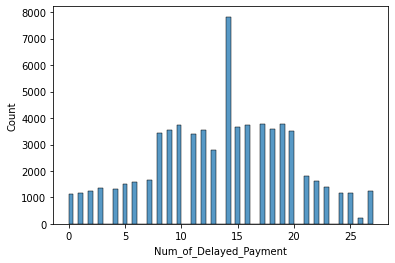

In [657]:
upper_lim = df.Num_of_Delayed_Payment.quantile(.99)
lower_lim = df.Num_of_Delayed_Payment.quantile(.01)
df.Num_of_Delayed_Payment = np.where(df.Num_of_Delayed_Payment > upper_lim, upper_lim, df.Num_of_Delayed_Payment)
df.Num_of_Delayed_Payment = np.where(df.Num_of_Delayed_Payment < lower_lim, upper_lim, df.Num_of_Delayed_Payment)
sns.histplot(df.Num_of_Delayed_Payment)

<AxesSubplot:xlabel='Num_of_Delayed_Payment', ylabel='Count'>

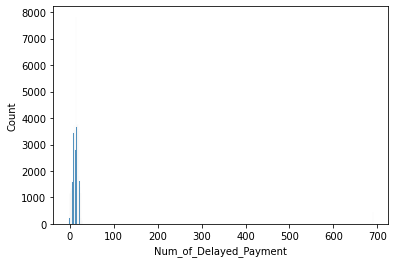

In [658]:
#Na pozór normalny, zobaczmy jednak jak nieefektywny byłby alternatywny sposób
upper_lim = dftest['Num_of_Delayed_Payment'].mean () + dftest['Num_of_Delayed_Payment'].std () * factor
lower_lim = dftest['Num_of_Delayed_Payment'].mean () - dftest['Num_of_Delayed_Payment'].std () * factor
dftest['Num_of_Delayed_Payment'] = np.where(dftest['Num_of_Delayed_Payment'] < upper_lim, dftest['Num_of_Delayed_Payment'], upper_lim)
dftest['Num_of_Delayed_Payment'] = np.where(dftest['Num_of_Delayed_Payment'] > lower_lim, dftest['Num_of_Delayed_Payment'], lower_lim)
sns.histplot(dftest.Num_of_Delayed_Payment)

In [659]:
#df.drop(columns=['Personal Loan','Student Loan','Payday Loan','Not Specified','Mortgage Loan', 'Home Equity Loan','Debt Consolidation Loan', 'Credit-Builder Loan', 'Auto Loan' ], inplace=True)

## Redukcja liczby zmiennych

In [660]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69882 entries, 0 to 69881
Data columns (total 32 columns):
 #   Column                    Non-Null Count  Dtype           
---  ------                    --------------  -----           
 0   Month                     69882 non-null  int64           
 1   Age                       69882 non-null  float64         
 2   Occupation                69882 non-null  object          
 3   Annual_Income             69882 non-null  float64         
 4   Monthly_Inhand_Salary     69882 non-null  float64         
 5   Num_Bank_Accounts         69882 non-null  float64         
 6   Num_Credit_Card           69882 non-null  float64         
 7   Interest_Rate             69882 non-null  float64         
 8   Num_of_Loan               69882 non-null  float64         
 9   Delay_from_due_date       69882 non-null  float64         
 10  Num_of_Delayed_Payment    69882 non-null  float64         
 11  Changed_Credit_Limit      69882 non-null  float64     

In [661]:
#dużo nanów to się pozbędziemy
df.drop(columns=['payment_value'], inplace = True)

<AxesSubplot:>

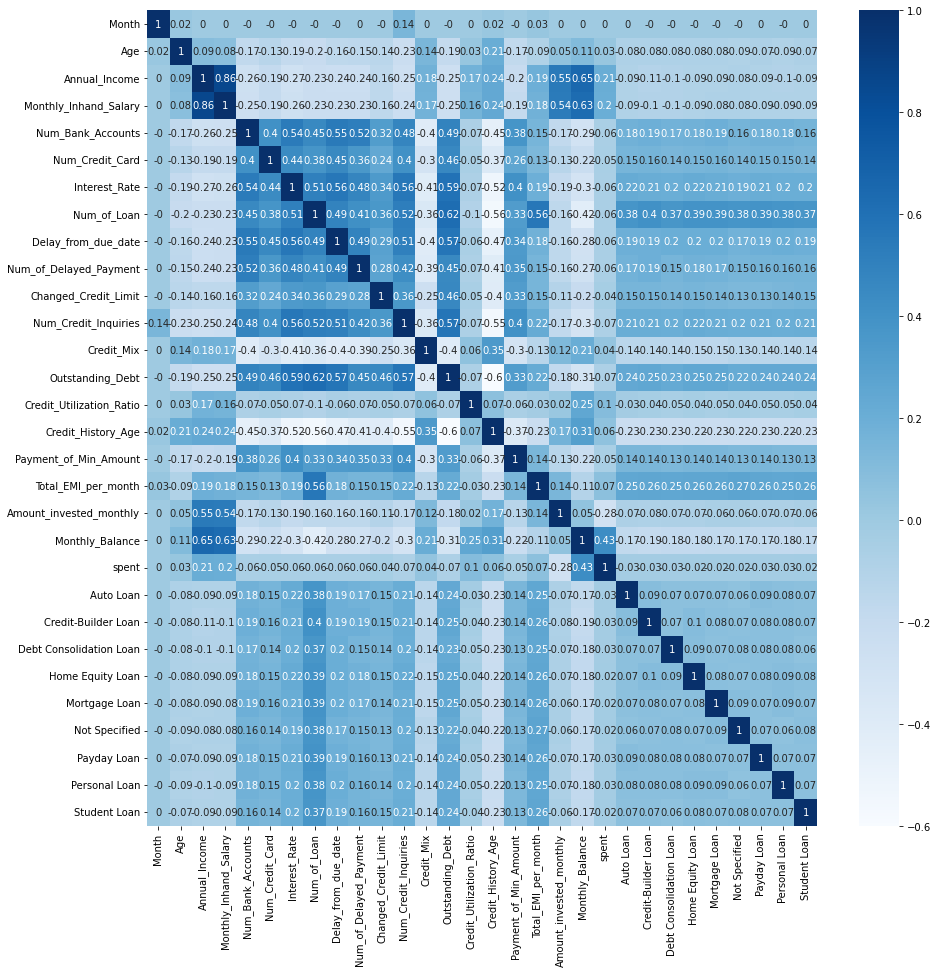

In [662]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(df.corr().round(2), cmap="Blues", annot=True)

In [663]:
df.columns

Index(['Month', 'Age', 'Occupation', 'Annual_Income', 'Monthly_Inhand_Salary',
       'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Credit_History_Age',
       'Payment_of_Min_Amount', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Monthly_Balance', 'spent', 'Auto Loan',
       'Credit-Builder Loan', 'Debt Consolidation Loan', 'Home Equity Loan',
       'Mortgage Loan', 'Not Specified', 'Payday Loan', 'Personal Loan',
       'Student Loan'],
      dtype='object')

In [664]:
#zawód i miesiąc są równomiernie rozłożone i nie wykazywały wpływu na rating kredytowy
df = df.drop(columns=['Occupation','Month'])
df.drop(columns=['Personal Loan','Student Loan','Payday Loan','Not Specified','Mortgage Loan', 'Home Equity Loan','Debt Consolidation Loan', 
'Credit-Builder Loan', 'Auto Loan' ], inplace=True)

In [665]:
#annual income i monthly salary bardzo skorelowane

In [666]:
df.Monthly_Inhand_Salary.corr(df_target)

0.004268996000720848

In [667]:
df.Annual_Income.corr(df_target)

0.007196975577020511

In [668]:
df = df.drop(columns=['Annual_Income'])

<AxesSubplot:>

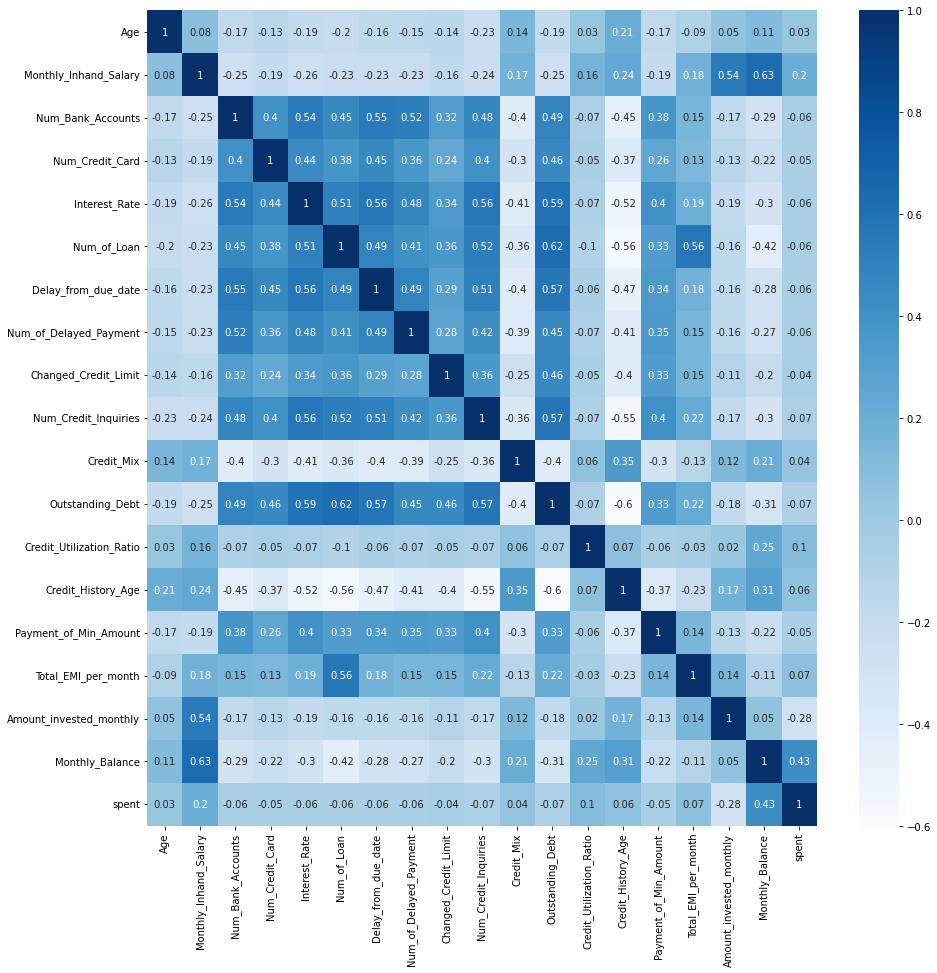

In [669]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(df.corr().round(2), cmap="Blues", annot=True)

In [670]:
df.info()
#ready :))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69882 entries, 0 to 69881
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       69882 non-null  float64
 1   Monthly_Inhand_Salary     69882 non-null  float64
 2   Num_Bank_Accounts         69882 non-null  float64
 3   Num_Credit_Card           69882 non-null  float64
 4   Interest_Rate             69882 non-null  float64
 5   Num_of_Loan               69882 non-null  float64
 6   Delay_from_due_date       69882 non-null  float64
 7   Num_of_Delayed_Payment    69882 non-null  float64
 8   Changed_Credit_Limit      69882 non-null  float64
 9   Num_Credit_Inquiries      69882 non-null  float64
 10  Credit_Mix                69882 non-null  int64  
 11  Outstanding_Debt          69882 non-null  float64
 12  Credit_Utilization_Ratio  69882 non-null  float64
 13  Credit_History_Age        69882 non-null  float64
 14  Paymen